In [69]:
import os
import numpy as np
from pandas import DataFrame

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = 12

In [70]:
DATASETS = {
            'Enron-1': [
                ('./ham-spam/data/enron1/ham', 'ham'),
                ('./ham-spam/data/enron1/spam', 'spam')
            ],
            'Enron-2': [
                ('./ham-spam/data/enron2/ham', 'ham'),
                ('./ham-spam/data/enron2/spam', 'spam')
            ],
            'Enron-3': [
                ('./ham-spam/data/enron3/ham', 'ham'),
                ('./ham-spam/data/enron3/spam', 'spam')
            ],
            'Enron-4': [
                ('./ham-spam/data/enron4/ham', 'ham'),
                ('./ham-spam/data/enron4/spam', 'spam')
            ],
            'Enron-5': [
                ('./ham-spam/data/enron5/ham', 'ham'),
                ('./ham-spam/data/enron5/spam', 'spam')
            ],
            'Enron-6': [
                ('./ham-spam/data/enron6/ham', 'ham'),
                ('./ham-spam/data/enron6/spam', 'spam')
            ]
}

In [71]:
NEWLINE = '\n'

# Read the content of a file
def read_files(path):
    for root, dir_names, file_names in os.walk(path):
        for dir_name in dir_names:
            pass
        for file_name in file_names:        
            file_path = os.path.join(path, file_name)
            lines = []
            f = open(file_path, mode='r', encoding='latin-1')
            for line in f:
                lines.append(line)
            f.close()
            content = NEWLINE.join(lines)
            yield file_path, content

# create a DataFrame by reading each files in the given directory
def create_data_frame(path, classification):
    rows = []
    index = []
    for file_path, content in read_files(path):
        rows.append({'e-mail-text':content, 'class':classification})
        index.append(file_path)
    data_frame = DataFrame(rows, index=index)
    return data_frame

In [72]:
from textblob import TextBlob
import re, nltk
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

In [73]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def lemmatize_tokens(tokens, lemmatizer):
    lemmatized = []
    for item in tokens:
        lemmatized.append(lemmatizer.lemmatize(item))
    return lemmatized

def tokenize(text):
    # remove non letters
    text = re.sub("[^a-zA-Z]", " ", text)
    # tokenize
    tokens = nltk.word_tokenize(text)
    # stem
    #stems = stem_tokens(tokens, stemmer)
    # lemmatize
    lemmas = lemmatize_tokens(tokens, lemmatizer)
    #return stems
    return lemmas

In [74]:
labels = ['ham', 'spam']
def display_confusion_matrix(cm, cmap):
    plt.figure()
    #figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.matshow(cm, cmap=cmap, interpolation='nearest')
    plt.title('confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks,labels)
    plt.ylabel('expected label')
    plt.xlabel('predicted label')

In [75]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
pipelines_tf = [
                Pipeline([
                    ('MultinomialNB TF', MultinomialNB(alpha=0.01))   # testing accuracy of Multinomial Naive Bayes
                ]),
                Pipeline([
                   ('BernoulliNB TF', BernoulliNB(alpha=0.01))       # testing accuracy of Bernoulli Naive Bayes
                ]),
                Pipeline([
                    ('GaussianNB TF', GaussianNB())                   # testing accuracy of Gaussian Naive Bayes
                ])                       
            ]
pipelines_tfidf = [
                Pipeline([
                    ('MultinomialNB TFIDF', MultinomialNB(alpha=0.01))   # testing accuracy of Multinomial Naive Bayes
                ]),
                Pipeline([
                    ('GaussianNB TFIDF', GaussianNB())                   # testing accuracy of Gaussian Naive Bayes
                ])       
            ]

In [ ]:
from sklearn import metrics
def benchmark_clf(clf, X_train, y_train, X_test):
    clf.fit(X_train.toarray(), y_train)
    
    # Predict the class and probability on the test data
    y_pred = clf.predict(X_test.toarray())
    y_pred_prob = clf.predict_proba(X_test.toarray())[:, 1]
    
    return y_pred, y_pred_prob

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cross_validation import train_test_split

key = 'Enron-4'
# create an initial DataFrame
enron_df = DataFrame({'e-mail-text':[], 'class':[]})
for path, classification in DATASETS[key]:
    enron_df = enron_df.append(create_data_frame(path, classification))

# shuffle entries so that ham and spam are not consecutively stored
#enron_df.reindex(np.random.permutation(enron_df.index))
#print(enron_df.head(10))

# stratified sampling of training and test data based on the distribution of ham and spam
X_train, X_test, y_train, y_test = train_test_split(enron_df['e-mail-text'], 
                                                    enron_df['class'], random_state=0, stratify=enron_df['class'])

# create the term frequency vectors
count_vect = CountVectorizer(analyzer = 'word', tokenizer=tokenize, lowercase=True, stop_words='english')
#count_vect = CountVectorizer(analyzer=split_into_lemmas)
count_vect.fit(enron_df['e-mail-text'])
#print(count_vect.get_feature_names)

X_train_tf = count_vect.transform(X_train)
print('sparse matrix shape:', X_train_tf.shape)
print('number of non-zeros:', X_train_tf.nnz)
print('sparsity: %.2f%%' % (100.0 * X_train_tf.nnz / (X_train_tf.shape[0] * X_train_tf.shape[1])))

# after the counting, the term weighting and normalization is done with TF-IDF
#tfidf_vect = TfidfVectorizer(analyzer=split_into_lemmas)
tfidf_vect = TfidfVectorizer(analyzer = 'word', tokenizer=tokenize, lowercase=True, stop_words='english')

tfidf_vect.fit(enron_df['e-mail-text'])
X_train_tfidf = tfidf_vect.transform(X_train)
print(X_train_tfidf.shape)

X_test_tf = count_vect.transform(X_test)
X_test_tfidf = tfidf_vect.transform(X_test)

results = []
for pipeline in pipelines_tf:
    y_pred, y_pred_prob = benchmark_clf(pipeline, X_train_tf, y_train, X_test_tf)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob, pos_label='spam')
    roc_auc = metrics.auc(fpr, tpr)
    results.append((pipeline.steps[-1][0], y_test, y_pred, y_pred_prob, fpr, tpr, roc_auc))
    
for pipeline in pipelines_tfidf:
    y_pred, y_pred_prob = benchmark_clf(pipeline, X_train_tf, y_train, X_test_tf)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob, pos_label='spam')
    roc_auc = metrics.auc(fpr, tpr)
    results.append((pipeline.steps[-1][0], y_test, y_pred, y_pred_prob, fpr, tpr, roc_auc))

sparse matrix shape: (4500, 61134)
number of non-zeros: 340156
sparsity: 0.12%
(4500, 61134)


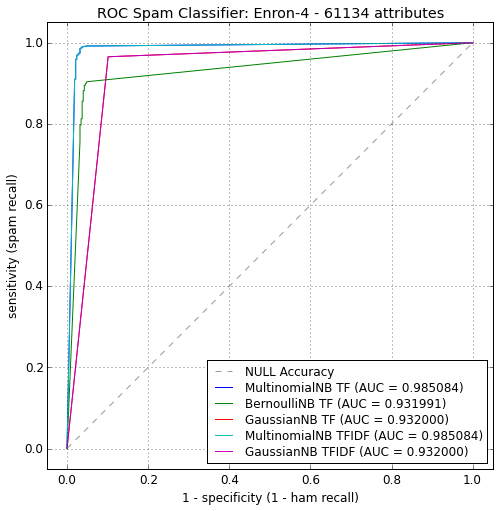

In [ ]:
plt.figure(figsize=(8,8))
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='NULL Accuracy')

for clf, y_test, y_pred, y_pred_prob, fpr, tpr, roc_auc in results:
    plt.plot(fpr, tpr, lw=1, label='%s (AUC = %0.6f)' % (clf, roc_auc))

plt.title('ROC Spam Classifier: %s - %s attributes' %('Enron-4', len(count_vect.get_feature_names())))
plt.xlabel('1 - specificity (1 - ham recall)')
plt.ylabel('sensitivity (spam recall)')
plt.legend(loc="lower right", fontsize = 'medium', labelspacing = 0.25)
plt.grid(True)

In [ ]:
key

'Enron-4'

Confusion Matrix: MultinomialNB TF
Confusion Matrix: BernoulliNB TF
Confusion Matrix: GaussianNB TF
Confusion Matrix: MultinomialNB TFIDF
Confusion Matrix: GaussianNB TFIDF


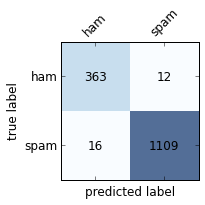

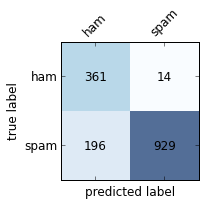

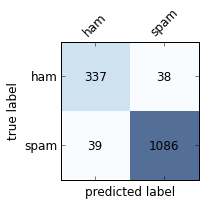

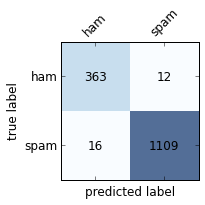

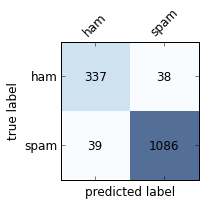

In [ ]:
from pylab import rcParams
labels = ['ham', 'spam']
for clf, y_test, y_pred, y_pred_prob, fpr, tpr, roc_auc in results:
    confmat = metrics.confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.7)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks,labels)
    plt.xlabel('predicted label')
    plt.ylabel('true label')
    plt.tight_layout()
    print('Confusion Matrix: %s' %(clf))

In [ ]:
for clf, y_test, y_pred, y_pred_prob, fpr, tpr, roc_auc in results:
    print('Metrics for %s:' % clf)
    # compute precision and recall, or their combination (harmonic mean) F1:
    print(metrics.classification_report(y_test, y_pred_class))